In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
# for text preprocessing
import re
import string
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords
# for PCA
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
# DBSCAN and KDistanceGraph
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors
from wordcloud import WordCloud

In [ ]:
# Load the Sentiment140 dataset
file_path = 'Sentiment_analysis.csv'
df = pd.read_csv(file_path, encoding='latin-1', header=None)

# Rename columns
df.columns = ['target', 'id', 'datetime', 'query', 'user', 'text']


In [ ]:
# Sample 10,000 tweets for efficiency
df_sampled = df.sample(n=10000, random_state=42)

In [ ]:
df_sampled.head()


,target,id,datetime,query,user,text
541200,0,2200003196,Tue Jun 16 18:18:12 PDT 2009,NO_QUERY,LaLaLindsey0609,@chrishasboobs AHHH I HOPE YOUR OK!!!
750,0,1467998485,Mon Apr 06 23:11:14 PDT 2009,NO_QUERY,sexygrneyes,"@misstoriblack cool , i have no tweet apps fo..."
766711,0,2300048954,Tue Jun 23 13:40:11 PDT 2009,NO_QUERY,sammydearr,@TiannaChaos i know just family drama. its la...
285055,0,1993474027,Mon Jun 01 10:26:07 PDT 2009,NO_QUERY,Lamb_Leanne,School email won't open and I have geography ...
705995,0,2256550904,Sat Jun 20 12:56:51 PDT 2009,NO_QUERY,yogicerdito,upper airways problem


In [ ]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
# function to clean the text
def clean_text(text):
    # Remove URLs
    text = re.sub(r'http\S+|www\S+', '', text)
    # Remove punctuation and make text lowercase
    text = text.translate(str.maketrans('', '', string.punctuation)).lower()
    # Remove stop words
    stop_words = set(stopwords.words('english'))
    text = " ".join([word for word in text.split() if word not in stop_words])
    return text

# Apply text cleaning to the 'text' column
df_sampled['cleaned_text'] = df_sampled['text'].apply(clean_text)

# Initialize TF-IDF vectorizer
vectorizer = TfidfVectorizer(max_features=1000)

# Apply TF-IDF vectorization
X_tfidf = vectorizer.fit_transform(df_sampled['cleaned_text'])

# Convert to DataFrame for inspection
X_tfidf_df = pd.DataFrame(X_tfidf.toarray(), columns=vectorizer.get_feature_names_out())

X_tfidf_df.head()


,10,100,12,15,16,1st,20,2day,2nd,30,...,yesterday,yet,youd,youll,youre,youtube,youve,yr,yummy,yup
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


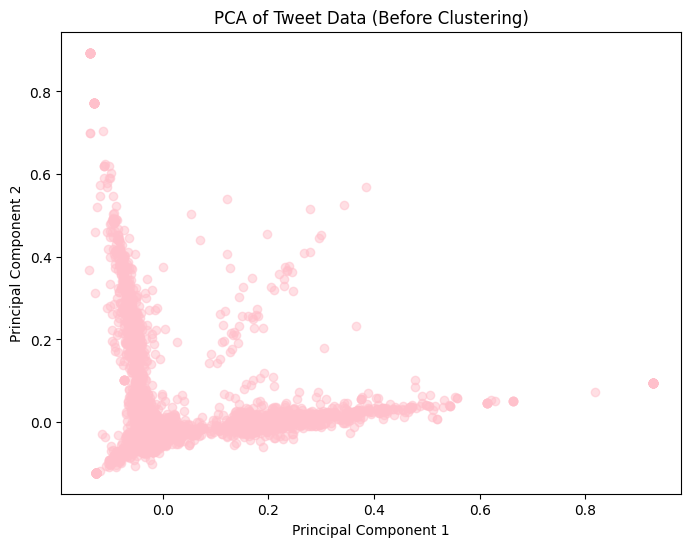

In [ ]:
# Apply PCA to reduce to 2 dimensions
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_tfidf.toarray())

# Plot the PCA-reduced data
plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c='pink', alpha=0.5)
plt.title('PCA of Tweet Data (Before Clustering)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()


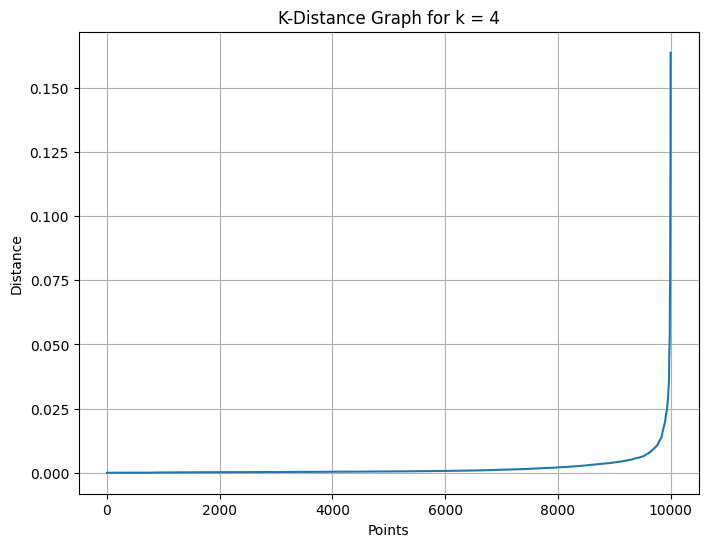

Optimal eps for k=4: 0.11818018465718853 at point 9996


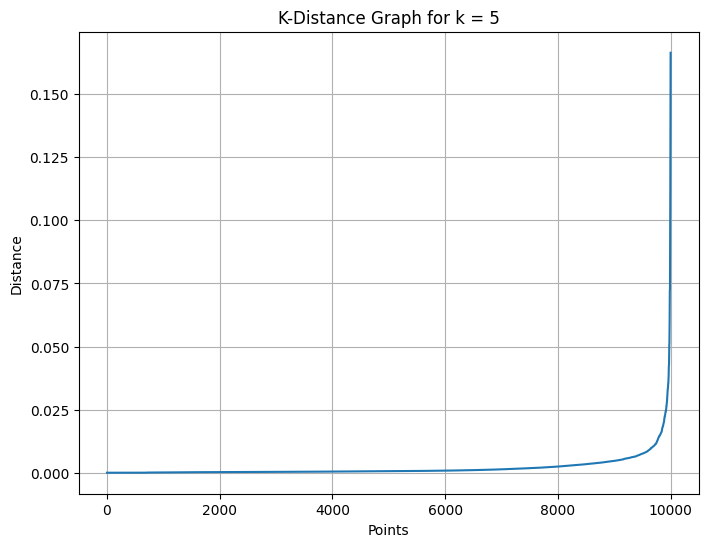

Optimal eps for k=5: 0.1333044923523612 at point 9996


In [ ]:
# Function to compute k-distance graph for different values of k
def plot_k_distance_graph(X_pca, k_values):
    for k in k_values:
        # Compute the k-distance graph
        neigh = NearestNeighbors(n_neighbors=k)
        nbrs = neigh.fit(X_pca)
        distances, indices = nbrs.kneighbors(X_pca)

        # Sort distances
        distances = np.sort(distances[:, k-1], axis=0)

        # Plot the k-distance graph
        plt.figure(figsize=(8, 6))
        plt.plot(distances)
        plt.title(f'K-Distance Graph for k = {k}')
        plt.xlabel('Points')
        plt.ylabel('Distance')
        plt.grid(True)
        plt.show()

        # Find the elbow point using second derivative for this k
        elbow_point, eps_optimal = find_elbow_point(distances)

        # Print the optimal eps and elbow point for this k
        print(f"Optimal eps for k={k}: {eps_optimal} at point {elbow_point}")

# Function to find the "elbow" using second derivative
def find_elbow_point(distances):
    # Calculate first derivative (slope)
    first_derivative = np.diff(distances)

    # Calculate second derivative (curvature)
    second_derivative = np.diff(first_derivative)

    # Find the point where the second derivative has the highest value (maximum curvature)
    elbow_point = np.argmax(second_derivative)

    return elbow_point, distances[elbow_point+1]  # +1 to adjust for diff length

k_values = [4, 5]

# Plot k-distance graphs and print optimal eps for each k
plot_k_distance_graph(X_pca, k_values)


In [ ]:
# Assuming you're interested in one of the k-values, e.g., k=5
k = 5  # Choose the value of k that looks good based on the graphs
neigh = NearestNeighbors(n_neighbors=k)
nbrs = neigh.fit(X_pca)
distances, indices = nbrs.kneighbors(X_pca)

# Sort distances for k-distance graph
distances = np.sort(distances[:, k-1], axis=0)

# Plot the k-distance graph for the chosen k
plt.figure(figsize=(8, 6))
plt.plot(distances)
plt.title(f'K-Distance Graph for k = {k}')
plt.xlabel('Points')
plt.ylabel('Distance')
plt.grid(True)
plt.show()


In [ ]:
# Apply DBSCAN with the optimal epsilon (for example, eps=0.1, min_samples=5)
db = DBSCAN(eps=0.13, min_samples=5)
db.fit(X_pca)

# Get the labels (clusters and noise)
labels = db.labels_

# Number of clusters and noise points
num_clusters = len(set(labels)) - (1 if -1 in labels else 0)  # Exclude noise
num_noise_points = list(labels).count(-1)

print(f'Number of clusters: {num_clusters}')
print(f'Number of noise points: {num_noise_points}')


Number of clusters: 2
Number of noise points: 0


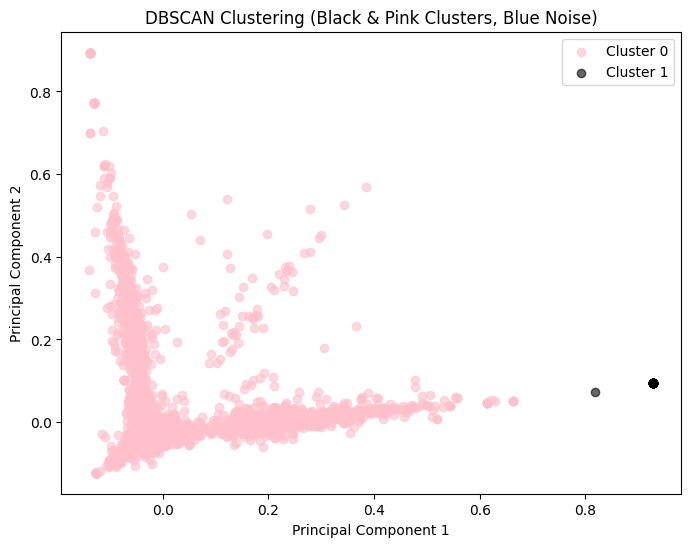

In [ ]:
plt.figure(figsize=(8, 6))

unique_labels = sorted(set(labels))
cluster_colors = ['pink', 'black']

for i, label in enumerate(unique_labels):
    if label == -1:
        color = 'blue'  # Noise
        label_text = 'Noise'
    else:
        color = cluster_colors[i % len(cluster_colors)]
        label_text = f'Cluster {label}'

    plt.scatter(
        X_pca[labels == label, 0],
        X_pca[labels == label, 1],
        color=color,
        label=label_text,
        alpha=0.6
    )

plt.title('DBSCAN Clustering (Black & Pink Clusters, Blue Noise)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.show()


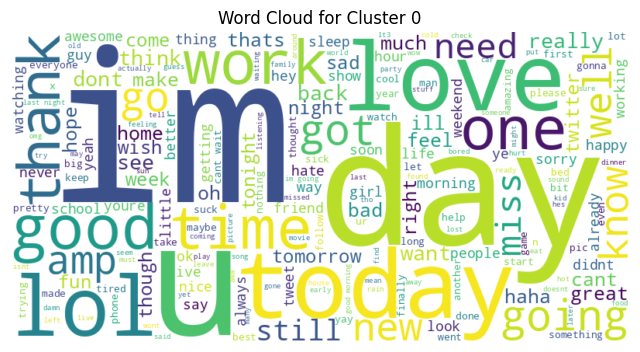

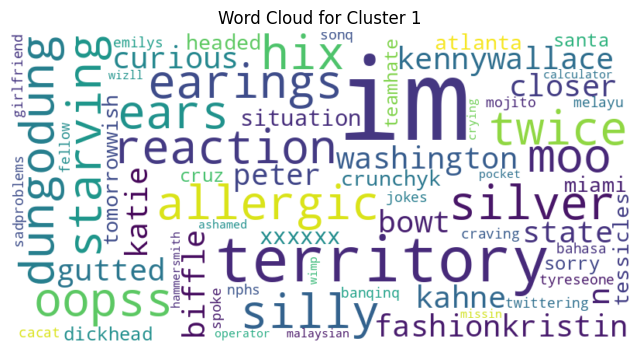

In [ ]:
from wordcloud import WordCloud

# Create a word cloud for each cluster
for label in unique_labels:
    if label != -1:
        cluster_tweets = df_sampled['cleaned_text'][labels == label]
        text = ' '.join(cluster_tweets)
        wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

        plt.figure(figsize=(8, 6))
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.title(f'Word Cloud for Cluster {label}')
        plt.axis('off')
        plt.show()


In [ ]:
# Function to compute k-distance graph for different values of k
def plot_k_distance_graph(X_pca, k_values):
    best_k = None
    best_eps = None
    best_elbow_point = None
    min_eps_diff = float('inf')  # Track the best eps with minimal difference (for sharpest elbow)

    for k in k_values:
        # Compute the k-distance graph
        neigh = NearestNeighbors(n_neighbors=k)
        nbrs = neigh.fit(X_pca)
        distances, indices = nbrs.kneighbors(X_pca)

        # Sort distances
        distances = np.sort(distances[:, k-1], axis=0)

        # Plot the k-distance graph
        plt.figure(figsize=(8, 6))
        plt.plot(distances)
        plt.title(f'K-Distance Graph for k = {k}')
        plt.xlabel('Points')
        plt.ylabel('Distance')
        plt.grid(True)
        plt.show()

        # Find the elbow point using second derivative for this k
        elbow_point, eps_optimal = find_elbow_point(distances)

        # Print the optimal eps and elbow point for this k
        print(f"Optimal eps for k={k}: {eps_optimal} at point {elbow_point}")

        # Track the best k based on minimal difference in eps values
        eps_diff = abs(eps_optimal - np.mean(distances))  # We can compare with the average or any other heuristic
        if eps_diff < min_eps_diff:
            min_eps_diff = eps_diff
            best_k = k
            best_eps = eps_optimal
            best_elbow_point = elbow_point

    # Print the best k and corresponding eps
    print(f"\nBest k: {best_k} with eps: {best_eps} (Elbow point at {best_elbow_point})")

# Function to find the "elbow" using second derivative
def find_elbow_point(distances):
    # Calculate first derivative (slope)
    first_derivative = np.diff(distances)

    # Calculate second derivative (curvature)
    second_derivative = np.diff(first_derivative)

    # Find the point where the second derivative has the highest value (maximum curvature)
    elbow_point = np.argmax(second_derivative)

    return elbow_point, distances[elbow_point+1]  # +1 to adjust for diff length

# List of k values to experiment with
k_values = [4, 5, 6, 7, 8, 9, 10]

# Plot k-distance graphs and print optimal eps for each k, then determine the best k and eps
plot_k_distance_graph(X_pca, k_values)


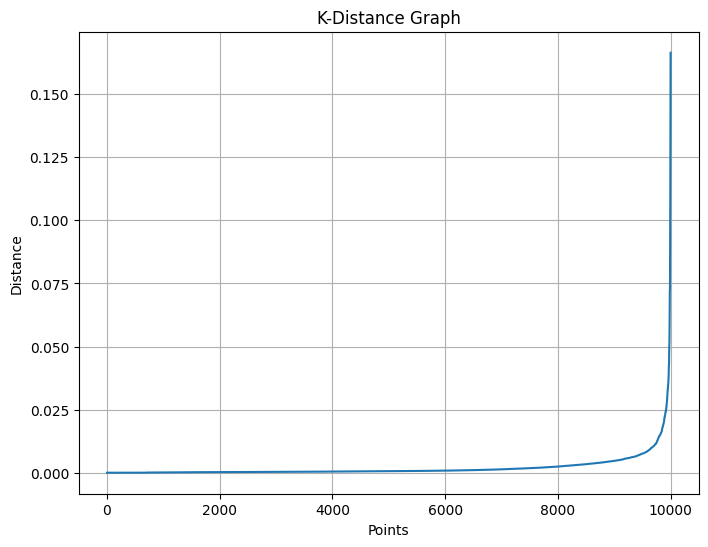

In [ ]:
# Compute k-distance graph to determine eps
k = 5  # You can experiment with different values of k
neigh = NearestNeighbors(n_neighbors=k)
nbrs = neigh.fit(X_pca)
distances, indices = nbrs.kneighbors(X_pca)

# Sort distances for k-distance graph
distances = np.sort(distances[:, k-1], axis=0)

# Plot the k-distance graph
plt.figure(figsize=(8, 6))
plt.plot(distances)
plt.title('K-Distance Graph')
plt.xlabel('Points')
plt.ylabel('Distance')
plt.grid(True)
plt.show()
